<a href="https://colab.research.google.com/github/netostr/practice-ML/blob/main/2/HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание 3

In [35]:
!pip install -q catalyst

In [36]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

from catalyst import utils

sns.set(style="darkgrid", font_scale=1.4)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [37]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))# YOUR CODE GOES HERE

    def forward(self, x):
        x = x @ self.weights# YOUR CODE GOES HERE
        if self.bias:
            x +=  self.bias_term # YOUR CODE GOES HERE
        return x

### Датасет

Давайте сгенерируем датасет и посмотрим на него!

In [38]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

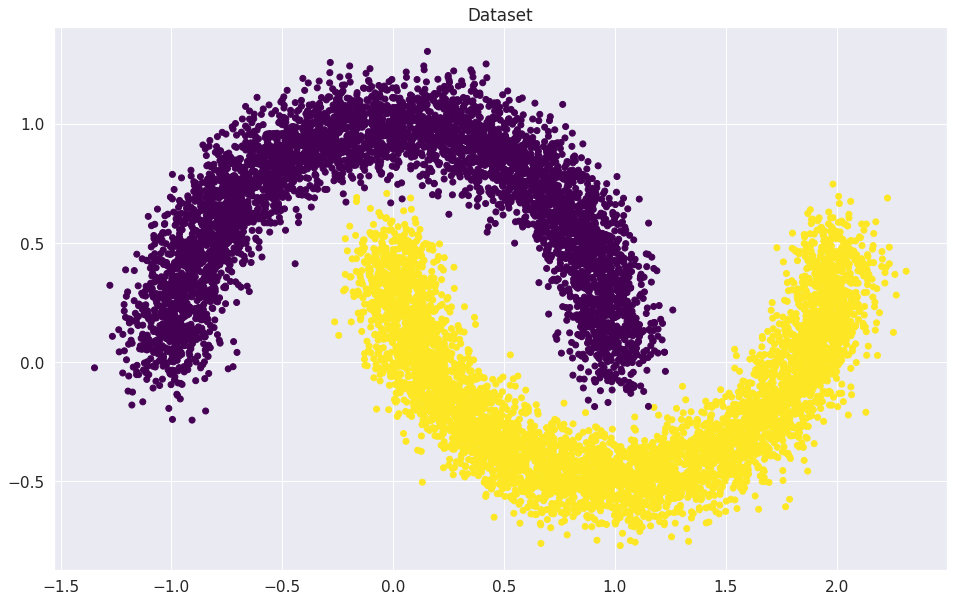

In [39]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных

В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.


In [41]:
X_train_t = torch.FloatTensor(X_train) # YOUR CODE GOES HERE
y_train_t = torch.FloatTensor(y_train) # YOUR CODE GOES HERE
X_val_t = torch.FloatTensor(X_val) # YOUR CODE GOES HERE
y_val_t = torch.FloatTensor(y_val) # YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`. 

In [42]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [43]:
utils.set_global_seed(42)
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1** Сколько обучаемых параметров у получившейся модели?

**Ответ:** 3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

In [44]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    utils.set_global_seed(42 + epoch)
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch) # YOUR CODE GOES HERE
        y_batch = y_batch.reshape(y_batch.shape[0], -1)
        loss = loss_function(outp, y_batch)# YOUR CODE GOES HERE
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = F.sigmoid(outp) # YOUR CODE GOES HERE
        preds = (probabilities>0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)
        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration: 0
Batch accuracy: 62.3125
Iteration: 7500
Batch accuracy: 63.5625
Iteration: 15000
Batch accuracy: 63.90625
Iteration: 22500
Batch accuracy: 63.96875
Iteration: 30000
Batch accuracy: 64.03125
Iteration: 37500
Batch accuracy: 64.03125
Iteration: 45000
Batch accuracy: 64.03125
Iteration: 52500
Batch accuracy: 64.03125
Iteration: 60000
Batch accuracy: 64.03125
Iteration: 67500
Batch accuracy: 64.03125
Iteration: 75000
Batch accuracy: 64.03125
Iteration: 82500
Batch accuracy: 64.03125
Iteration: 90000
Batch accuracy: 64.03125

Iteration: 90047.Convergence. Stopping iterations.


**Вопрос 2**

Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 90047

### Визуализируем результаты

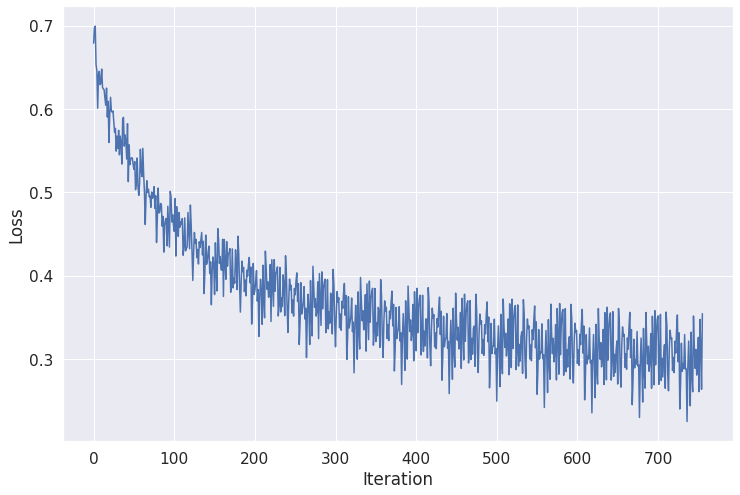

In [45]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

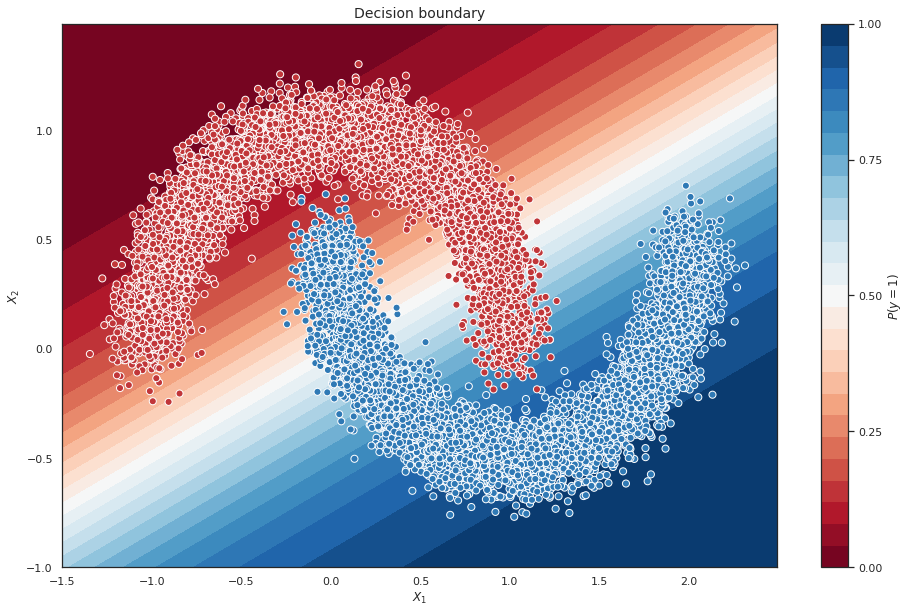

In [46]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [47]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

In [48]:
from sklearn.metrics import accuracy_score

# YOUR CODE GOES HERE
y_pred = predict(val_dataloader, linear_regression)
accuracy_score(y_val_t, y_pred)

0.862

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.862

### MNIST

In [79]:
import os
from catalyst.contrib.datasets import MNIST
from catalyst.data.transforms import ToTensor

train_dataset = MNIST(root=os.getcwd(), train=True, download=True, transform=ToTensor())
val_dataset = MNIST(root=os.getcwd(), train=False, transform=ToTensor())
train_dataloader =  DataLoader(train_dataset, batch_size=128, drop_last=True)# YOUR CODE GOES HERE
valid_dataloader =  DataLoader(val_dataset, batch_size=128, drop_last=True)# YOUR CODE GOES HERE

In [80]:
class Identical(nn.Module):
    def forward(self, x):
        return x

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.size(0)
        return x.view(batch_size, -1)

In [92]:
activation = nn.ELU

model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [93]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [83]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [94]:
model.to(device)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=10, bias=True)
)

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

In [95]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42 + epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                 # YOUR CODE GOES HERE
                 model.train()  # <------------------ переводим модель в режим train
                 optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                 outp = model(x_batch)
            else:
                 # YOUR CODE GOES HERE
                 model.eval()  # <------------------ переводим модель в режим eval
                 with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            preds = outp.argmax(-1)
            correct = (preds.flatten() == y_batch).type(torch.float32).sum()# YOUR CODE GOES HERE
            all =  x_batch.size(0)# YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # YOUR CODE GOES HERE
                # YOUR CODE GOES HERE
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8849492521367521
Loader: valid. Accuracy: 0.8918269230769231
Epoch: 2
Loader: train. Accuracy: 0.9471988514957265
Loader: valid. Accuracy: 0.947830815018315
Epoch: 3
Loader: train. Accuracy: 0.962890625
Loader: valid. Accuracy: 0.9626116071428571
Epoch: 4
Loader: train. Accuracy: 0.9726395566239316
Loader: valid. Accuracy: 0.9717691163003663
Epoch: 5
Loader: train. Accuracy: 0.9790998931623932
Loader: valid. Accuracy: 0.9776356456043956
Epoch: 6
Loader: train. Accuracy: 0.9838908920940171
Loader: valid. Accuracy: 0.9819425366300366
Epoch: 7
Loader: train. Accuracy: 0.9879139957264957
Loader: valid. Accuracy: 0.9854767628205128
Epoch: 8
Loader: train. Accuracy: 0.9902009882478633
Loader: valid. Accuracy: 0.9875658195970696
Epoch: 9
Loader: train. Accuracy: 0.9923711271367521
Loader: valid. Accuracy: 0.9893257783882784
Epoch: 10
Loader: train. Accuracy: 0.9937399839743589
Loader: valid. Accuracy: 0.9902415293040293


Попробуйте разные функции активации. Позапускайте ячейки сверху несколько раз изменив функции активации. После каждого обучения запустите одну из ячеек снизу. Таким образом мы получим график accuracy/epoch для каждой функции активации.

In [86]:
plain_accuracy = accuracy["valid"]

In [96]:
relu_accuracy = accuracy["valid"]

In [91]:
leaky_relu_accuracy = accuracy["valid"]

In [59]:
elu_accuracy = accuracy["valid"]

### Accuracy

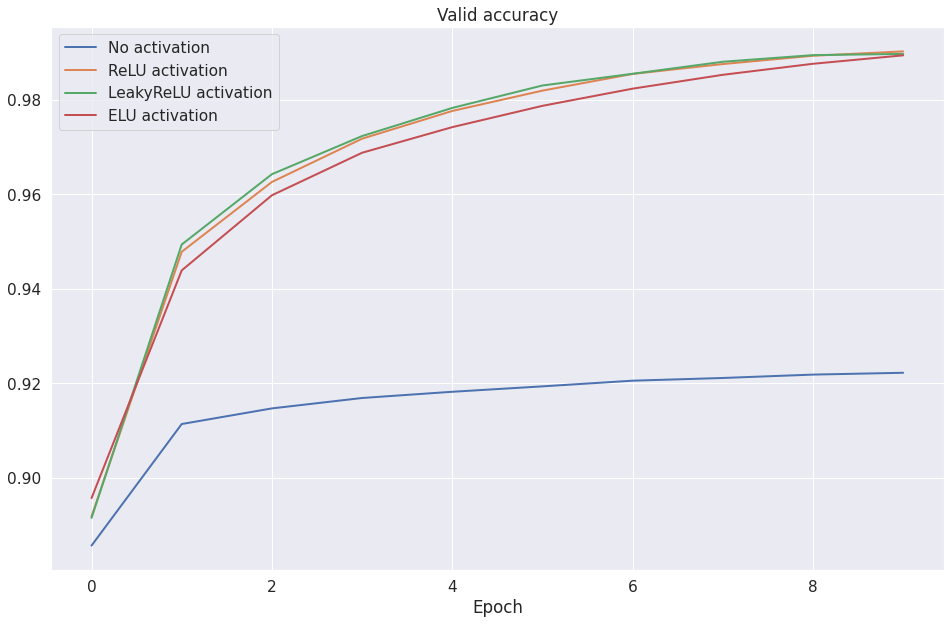

In [97]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

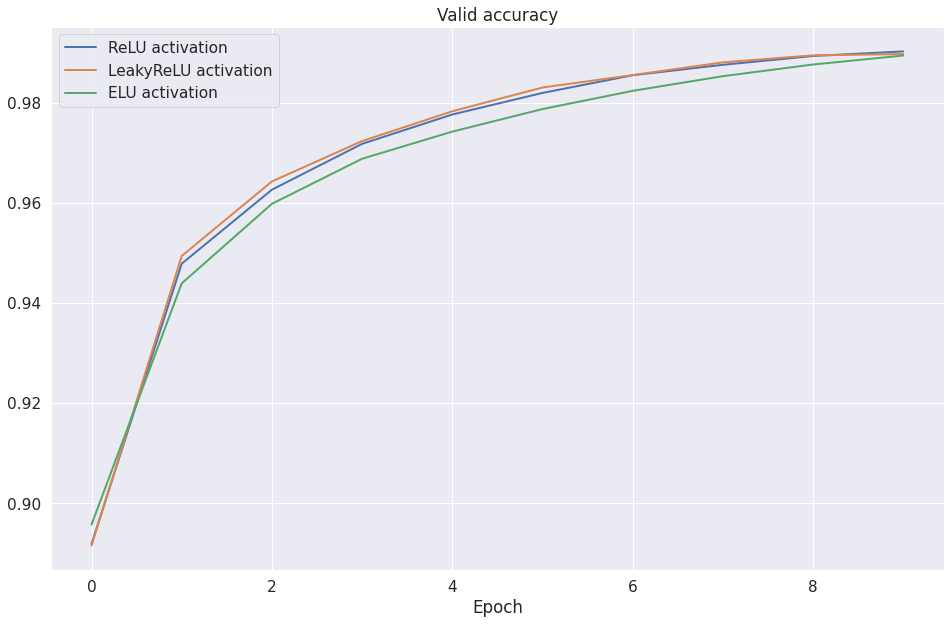

In [98]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [99]:
plain_accuracy[-1], relu_accuracy[-1], leaky_relu_accuracy[-1], elu_accuracy[-1]

(0.9222327152014652, 0.9902415293040293, 0.9897121108058609, 0.98941163003663)

**Вопрос 4** Какая из активаций показала наивысший `accuracy`?

**Ответ:** relu_accuracy

## Сверточные слои

### Ядра

In [100]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2021-04-05 07:01:02--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2021-04-05 07:01:02--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.02s   

2021-04-05 07:01:02 (1.90 MB/s) - ‘sample_photo.jpg’ saved [49337/

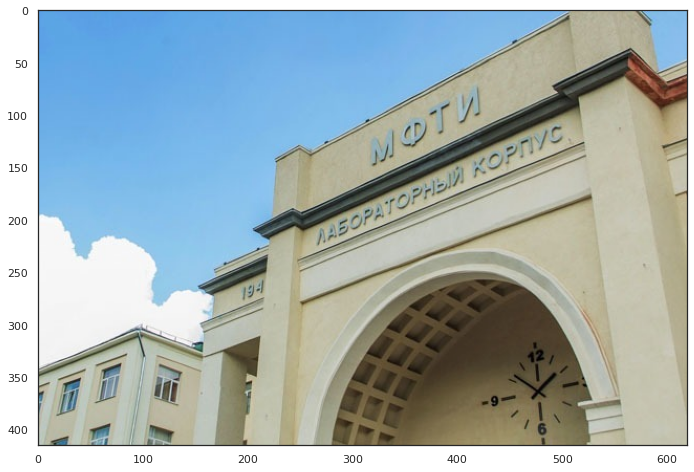

In [101]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [116]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


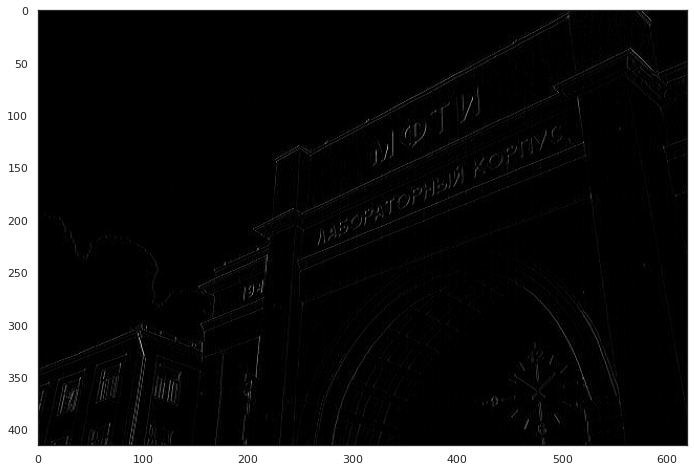

In [117]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5** Как вы считаете, как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

### LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Давайте посмотрим на архитектуру, предложенную еще в 1998 году!

In [118]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [119]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [124]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42+epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                 # YOUR CODE GOES HERE
                 model.train()  # <------------------ переводим модель в режим train
                 optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                 outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds.flatten() == y_batch).type(torch.float32).sum() # YOUR CODE GOES HERE
            all = x_batch.size(0) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # YOUR CODE GOES HERE
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9581997863247863
Loader: valid. Accuracy: 0.9597928113553114
Epoch: 2
Loader: train. Accuracy: 0.9711037660256411
Loader: valid. Accuracy: 0.971926510989011
Epoch: 3
Loader: train. Accuracy: 0.9775474091880342
Loader: valid. Accuracy: 0.9779790521978022
Epoch: 4
Loader: train. Accuracy: 0.9820880074786325
Loader: valid. Accuracy: 0.98211423992674
Epoch: 5
Loader: train. Accuracy: 0.9846921741452992
Loader: valid. Accuracy: 0.9843606913919414
Epoch: 6
Loader: train. Accuracy: 0.9870125534188035
Loader: valid. Accuracy: 0.9863782051282052
Epoch: 7
Loader: train. Accuracy: 0.9889823717948718
Loader: valid. Accuracy: 0.9878806089743589
Epoch: 8
Loader: train. Accuracy: 0.9907017895299145
Loader: valid. Accuracy: 0.9896834935897436
Epoch: 9
Loader: train. Accuracy: 0.9917367788461539
Loader: valid. Accuracy: 0.9906850961538461
Epoch: 10
Loader: train. Accuracy: 0.9927383814102564
Loader: valid. Accuracy: 0.9916866987179487


In [125]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

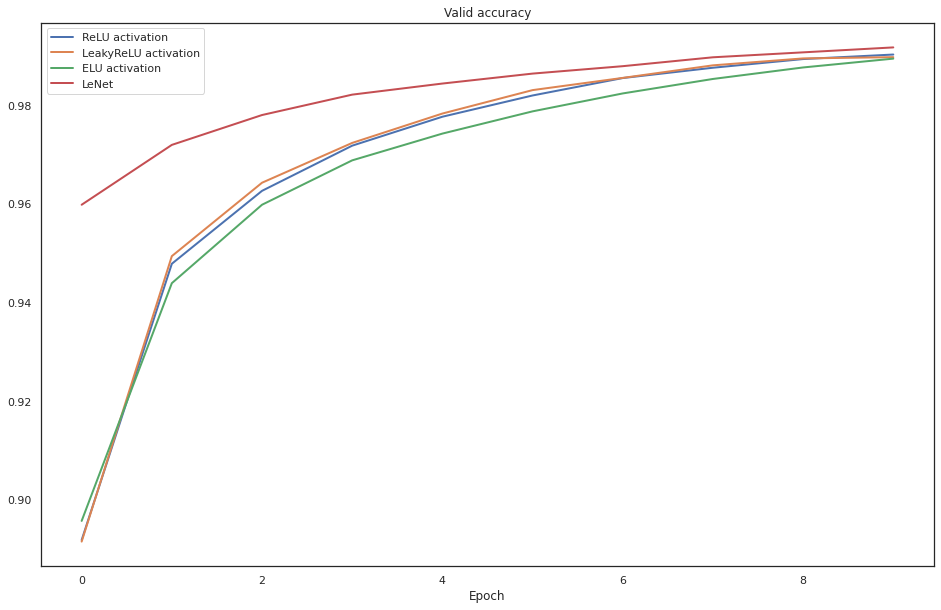

In [126]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99